In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from GA_functions import fitness, select_parents, crossover, mutation, GA_algorithm, conc_to_spectra, normalize_and_pca

## Many iterations

In [2]:
#This block of code creates random concentrations and spectra to start the algorithm. 
Sample_concentrations = pd.read_excel('../../../data/Sample_concentrations.xlsx')
red_conc = Sample_concentrations[['Red vol frac']].values
green_conc = Sample_concentrations[['Green vol frac']].values
blue_conc = Sample_concentrations[['Blue vol frac']].values
sample_conc = np.hstack((red_conc, green_conc, blue_conc))

sample_spectra = pd.read_excel('../../../data/Sample_spectra.xlsx')
sample_spectra = np.asarray(sample_spectra)
red = sample_spectra[:,1]
green = sample_spectra[:,2]
blue = sample_spectra[:,3]
wavelength = sample_spectra[:,0]

conc_array = np.random.dirichlet((1, 1, 1), 10)
spectra_array = conc_to_spectra(conc_array, red, green, blue, wavelength)

In [3]:
#best_conc_lst = []
#for i in range(20):


y_train = sample_conc[0:-1,:]
x_train = sample_spectra[:,1:-1]
objective_row = -1 #Change this number for a different concentration to test. 
x_test = sample_spectra[:,objective_row].reshape(-1,1) 
print('The target conc is:', sample_conc[objective_row,:])
print(conc_array)
print()

######## Use this if the starting concentrations and spectra from excel are to be used ###########
#y_train = sample_conc[0:-1,:]
#y_train_conc = y_train
##################################################################################################


######## Use this for random starting concentrations and spectra #################################
x_train = spectra_array.T
y_train_conc = conc_array 
##################################################################################################


#Normalizae x_train
x_train = MinMaxScaler().fit(x_train).transform(x_train)
x_test = MinMaxScaler().fit(x_test).transform(x_test).T
x_train = x_train.T
x_test = x_test.reshape(1,-1)[0].reshape(-1,1).T

pca = PCA(n_components=3)
x_train_new = pca.fit(x_train)
x_train_spectra = pca.transform(x_train)
x_test = pca.transform(x_test)

best_gen0 = fitness(x_train_spectra, y_train_conc, x_test)
best_conc = best_gen0[-1,x_train_spectra.shape[1]:-1]

gen_concs = [y_train_conc]
best_conc_list = [best_conc]
for i in range(40):
    gen2_spectra = conc_to_spectra(gen_concs[i], red, green, blue, wavelength)
    #gen2_spectra = normalize_and_pca(gen2_spectra)
    x_train = gen2_spectra.T
    x_train = MinMaxScaler().fit(x_train).transform(x_train)
    x_train = x_train.T

    gen2_spectra = pca.transform(x_train)
     
    gen3 = GA_algorithm(gen2_spectra, gen_concs[i], x_test, 20, 10, 0.8)
    gen_concs.append(gen3)
    print(gen3)
    print()
    #best_gen5 = fitness(gen2_spectra, gen_concs[i], x_test)
    #best_conc = best_gen5[-1,3:-1]
    #best_conc_list.append(best_conc)


The target conc is: [0.5073313  0.01445543 0.47821328]
[[0.24713174 0.19222629 0.56064197]
 [0.74991582 0.07214878 0.1779354 ]
 [0.54257527 0.15283158 0.30459315]
 [0.18653822 0.1918819  0.62157988]
 [0.11566577 0.0125104  0.87182383]
 [0.48885277 0.11887684 0.3922704 ]
 [0.69289077 0.25124366 0.05586558]
 [0.19880382 0.60784972 0.19334646]
 [0.00378866 0.02386155 0.97234979]
 [0.59574466 0.38457597 0.01967937]]

[[0.51274788 0.14353163 0.34372049]
 [0.50413223 0.12190083 0.37396694]
 [0.53982301 0.15142576 0.30875123]
 [0.36781609 0.14614122 0.48604269]
 [0.50185874 0.17843866 0.3197026 ]
 [0.37254902 0.38655462 0.24089636]
 [0.53650442 0.12942478 0.3340708 ]
 [0.39249639 0.37373737 0.23376623]
 [0.46081209 0.1680831  0.37110482]
 [0.49045226 0.11557789 0.39396985]]

[[0.50347567 0.12611718 0.37040715]
 [0.52772074 0.12936345 0.34291581]
 [0.54994851 0.1277034  0.32234809]
 [0.31015299 0.13838665 0.55146036]
 [0.49156118 0.13607595 0.37236287]
 [0.57752256 0.09926169 0.32321575]
 [0.7

In [4]:
mean_red = []
mean_green = []
mean_blue = []

for i in range(len(gen_concs)):
    mean_row = np.mean(gen_concs[i], axis = 0)
    mean_red.append(mean_row[0])
    mean_green.append(mean_row[1])
    mean_blue.append(mean_row[2])
print(np.mean(mean_red))
print(np.mean(mean_green))
print(np.mean(mean_blue))

    

0.4555695413875431
0.10982342757832049
0.43460703103413634


In [5]:
np.mean(gen3, axis=0)

array([0.43878158, 0.10377373, 0.45744469])

In [6]:
x_test

array([[-0.61239457, -0.2864288 , -0.57022411]])

In [13]:
def spectra_from_conc(action, RED, GREEN, BLUE):
    """Transforms actions and input into output."""
    fract = normalize_to_fraction(action)
    return RED*fract[0] + GREEN*fract[1] + BLUE*fract[2]

def normalize_to_fraction(action):
    """Returns the fraction of total volume given the concentrations (action)."""
    total = np.sum(action)
    return action / total

In [16]:
target_spectra=sample_spectra[:,objective_row]
sample_spectra = pd.read_excel('../../../data/Sample_spectra.xlsx')
sample_spectra = np.asarray(sample_spectra)
# spectra of base dyes
RED = sample_spectra[:,1]
GREEN = sample_spectra[:,2]
BLUE = sample_spectra[:,3]

<ipython-input-17-5010e661da5b>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


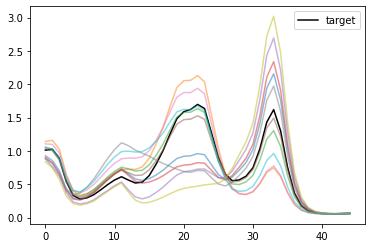

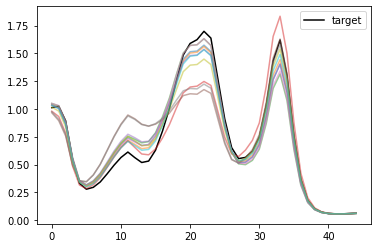

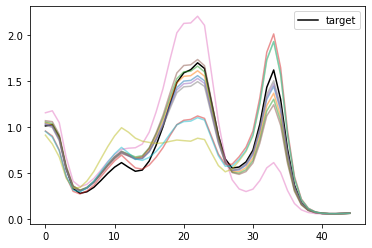

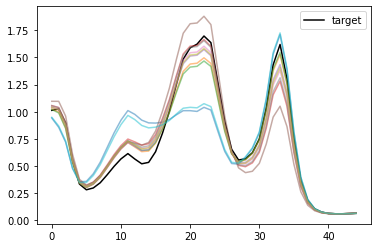

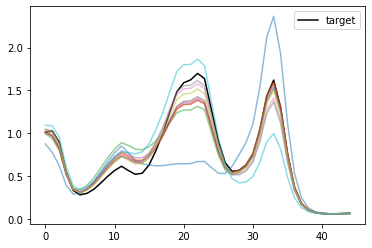

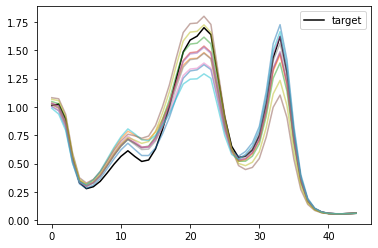

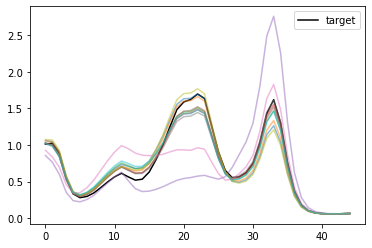

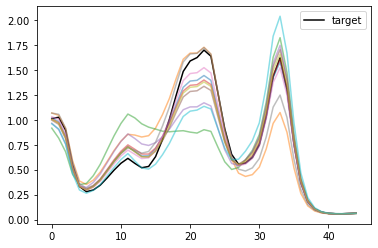

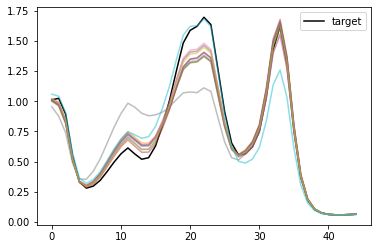

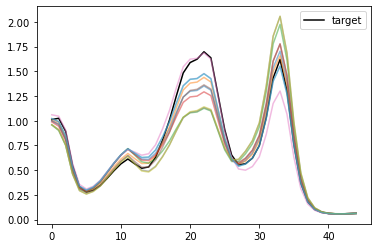

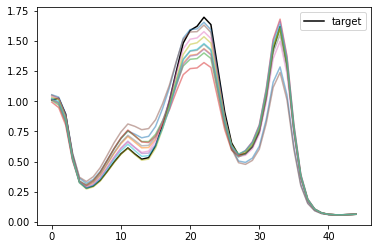

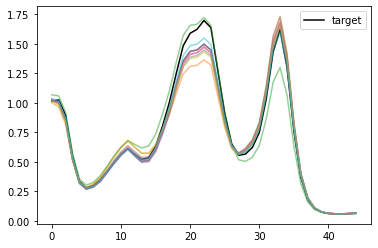

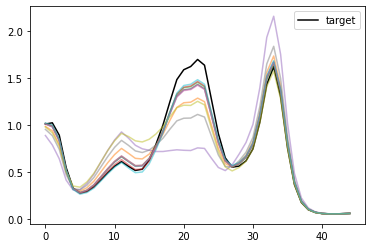

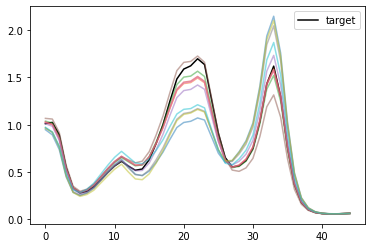

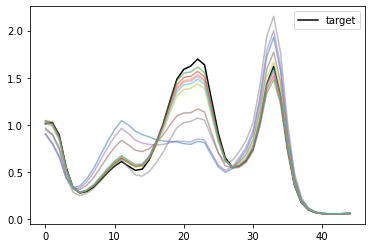

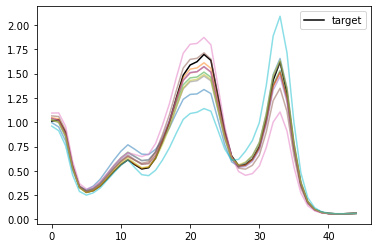

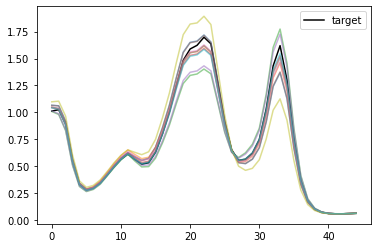

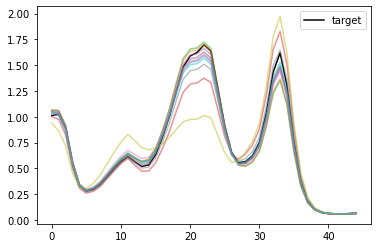

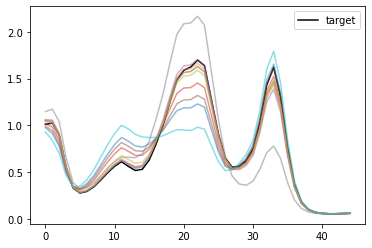

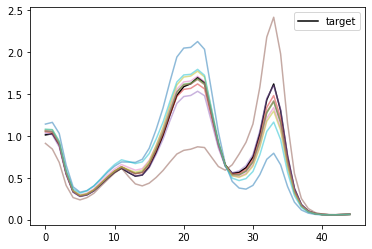

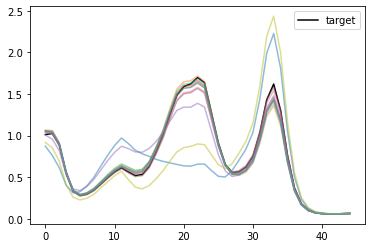

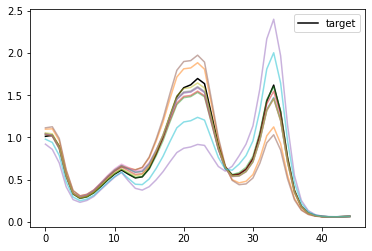

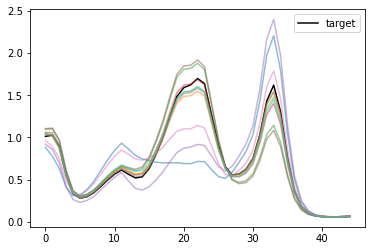

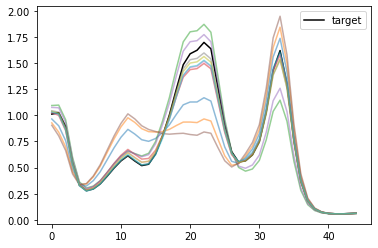

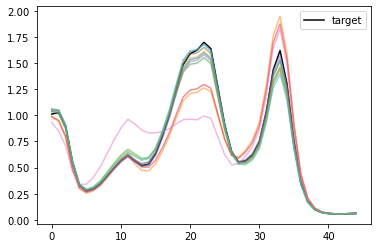

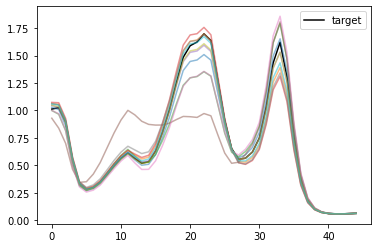

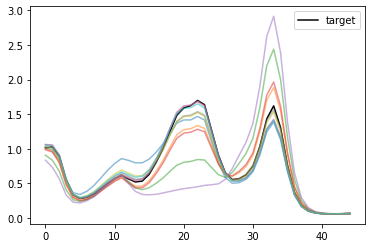

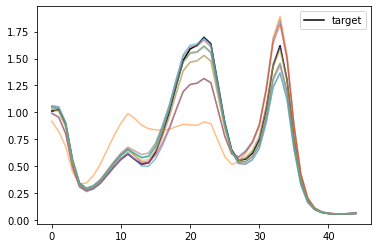

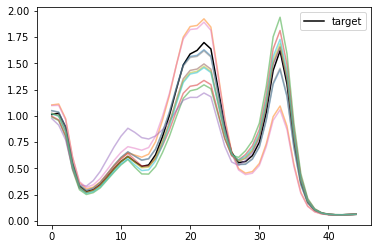

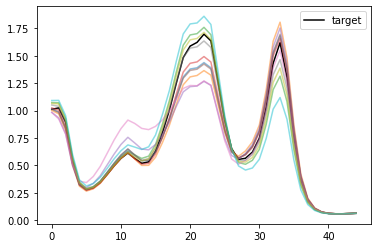

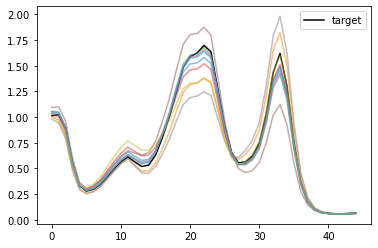

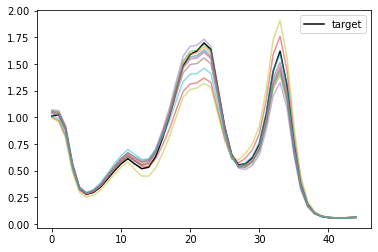

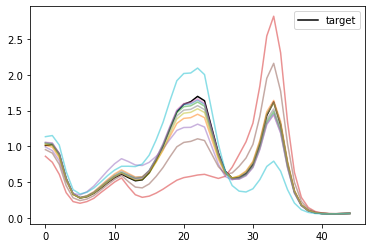

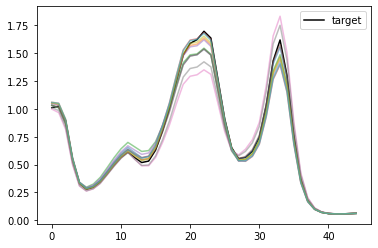

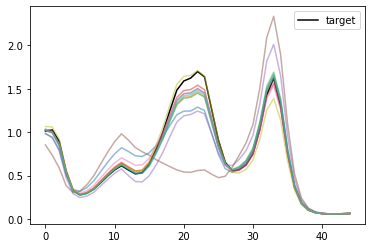

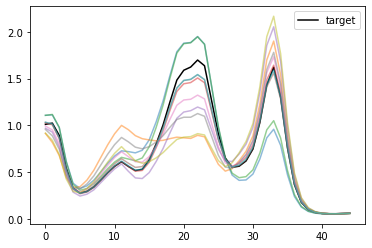

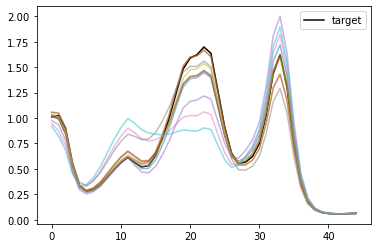

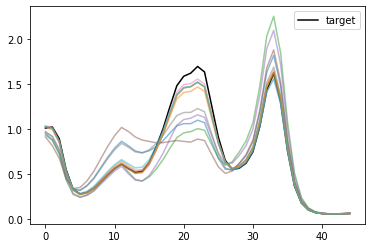

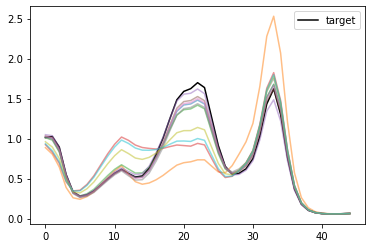

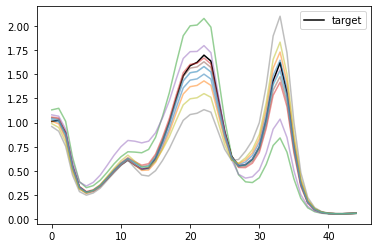

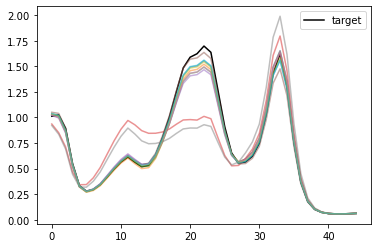

In [17]:
for epoch in gen_concs:
    plt.figure()
    plt.plot(target_spectra, color='black', label='target')
    for sol in epoch:
        spec = spectra_from_conc(sol, RED, GREEN, BLUE)
        plt.plot(spec, alpha=.5)
    plt.legend()